In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-etryk_03 because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [3]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)

start_points = all_points[:,0,1:]
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 154 pickup attempts
std of:  0.17447834259676462
shape before reducing dimension (154, 64, 8)
dataset variance of: [0.00197013 0.0012774  0.00135245 0.00687806 0.0256     0.00588592
 0.00669464]


In [4]:
dataset = start_points
dataset

array([[ 0.03644411, -0.05664173, -0.01726175, ...,  0.05311595,
         0.03802196,  0.04693789],
       [-0.07453766, -0.01680912, -0.0215112 , ..., -0.05982878,
        -0.04222452, -0.07548245],
       [ 0.00971311, -0.02070482, -0.03210563, ...,  0.05624359,
         0.00829467,  0.04349922],
       ...,
       [-0.01814567,  0.012406  , -0.01415396, ..., -0.08273447,
        -0.04929883,  0.05353723],
       [-0.0386492 ,  0.02261964,  0.00349406, ..., -0.24490761,
        -0.07656989,  0.03259478],
       [ 0.01510075, -0.00209672, -0.00561974, ...,  0.21811145,
         0.10821248,  0.05325818]])

<IPython.core.display.Javascript object>


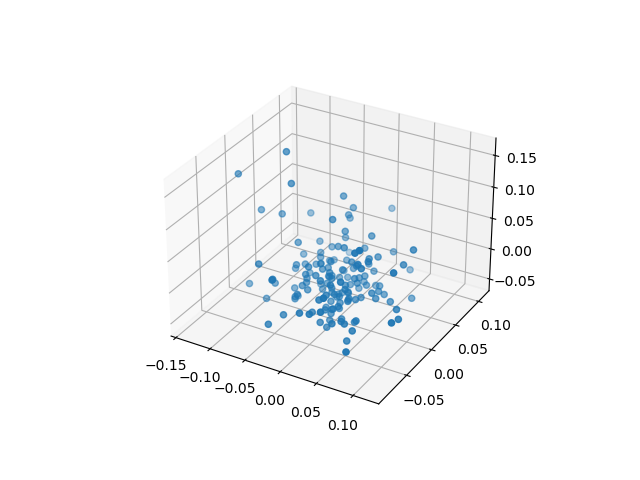

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);

<IPython.core.display.Javascript object>


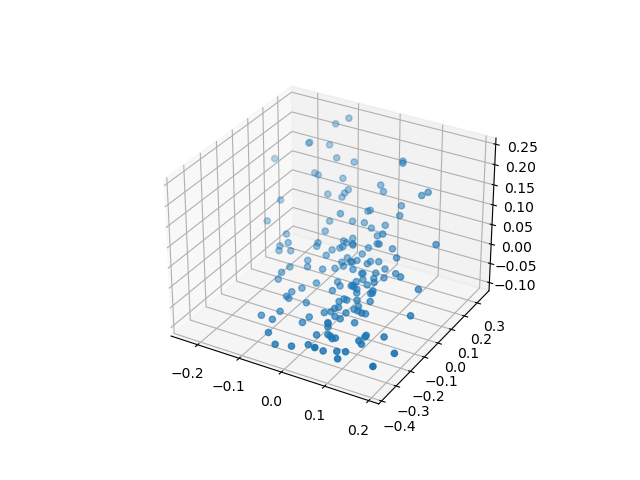

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);

## 2D VAE Fit to Dataset

In [7]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [8]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
  

In [9]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [10]:
testname = "const_delta_higher_curv_samp/annealeps"

In [11]:
all_models=[]
all_exceptions = []
for lr in [0.0005,0.0001]:
    for beta in [0.00001,0.0001,0.001,0.01]:
        for curvreg in [0,0.0002,0.0004,0.0008,0.001]:#,1,10,100,1000]:
            secreg = 0
            for latentdim in [2]:
                for epsilon_scale_start in [1]:
                    epsilon_scale = epsilon_scale_start
                    try:
                        vae = make_vae(latent_dim=latentdim).to(device)
                        num_epochs = 600
                        savedir  = f'{testname}lat{latentdim}_lr{lr}_curvreg{curvreg}_es{epsilon_scale_start}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                        print(savedir)
                        trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
                            log_dir=savedir, lr=lr, annealingBatches=0, record_loss_every=200, loss_func = "gaussian")
                        scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=1.0)
                        epoch = 0
                        for _ in range(num_epochs*3):
                            epoch+=1
                            # had an off-by-one error here before
                            # update values BEFORE training 501st element
                            if epoch % num_epochs == 1 and epoch > 1: 
                                scheduler.step()
                                epsilon_scale = epsilon_scale * np.sqrt(0.5)
                            # up num sample points to reduce variance of curvature measure
                            embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=curvreg, epsilon_scale = epsilon_scale, num_new_samp_points=512)
                            is_error = embst[0]
                            if is_error:
                                raise Exception
                        sm.save_fcpassthrough_vae(vae, savedir)
                        print(savedir)
                        all_models.append(savedir)
                    except:
                        all_exceptions.append(embst)
                        print("error")

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta1e-05_20220208-160220
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta1e-05_20220208-160220
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0002_es1_beta1e-05_20220208-160414
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0002_es1_beta1e-05_20220208-160414
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0004_es1_beta1e-05_20220208-160605
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0004_es1_beta1e-05_20220208-160605
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0008_es1_beta1e-05_20220208-160757
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0008_es1_beta1e-05_20220208-160757
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950
const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950
const_delta_higher_curv_samp/annealepslat2_lr0.0005_

In [12]:
np.random.uniform(1,2) * epsilon_scale

0.855588454688825

In [13]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [14]:
def make_2d_grid_points(xmin, xmax, ymin, ymax, ):
    #lim = 6
    num_few = 7
    num_many = 100
    pts = []
    for x in np.linspace(xmin, xmax, num_few):
        for y in np.linspace(ymin, ymax, num_many):
                pts.append((x,y))
    for y in np.linspace(ymin, ymax, num_few):
        for x in np.linspace(xmin, xmax, num_many):
                pts.append((x,y))
    return np.array(pts)

<IPython.core.display.Javascript object>


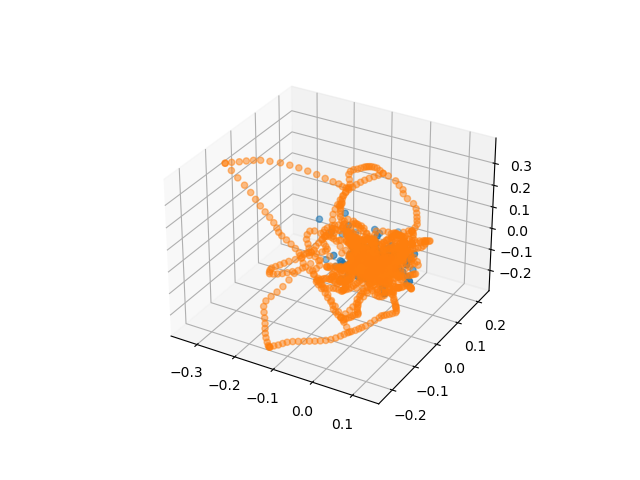

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta1e-05_20220208-160220


<IPython.core.display.Javascript object>


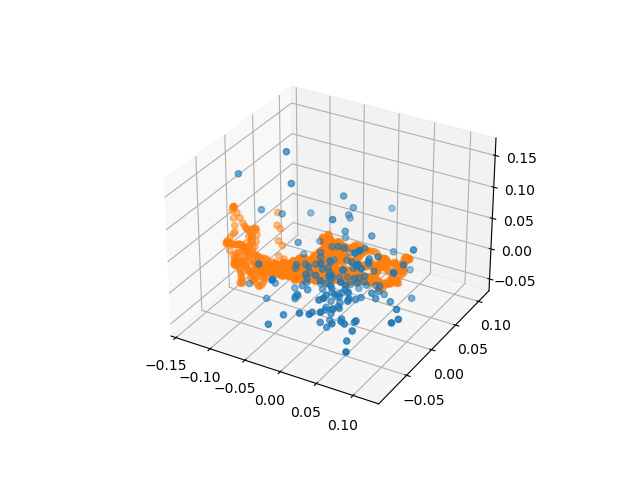

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0002_es1_beta1e-05_20220208-160414


<IPython.core.display.Javascript object>


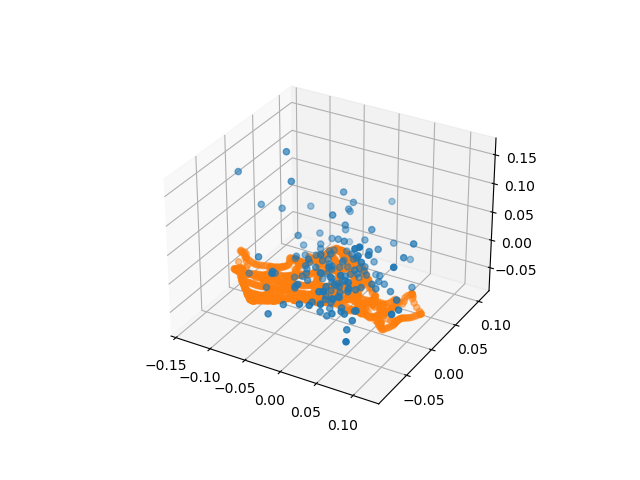

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0004_es1_beta1e-05_20220208-160605


<IPython.core.display.Javascript object>


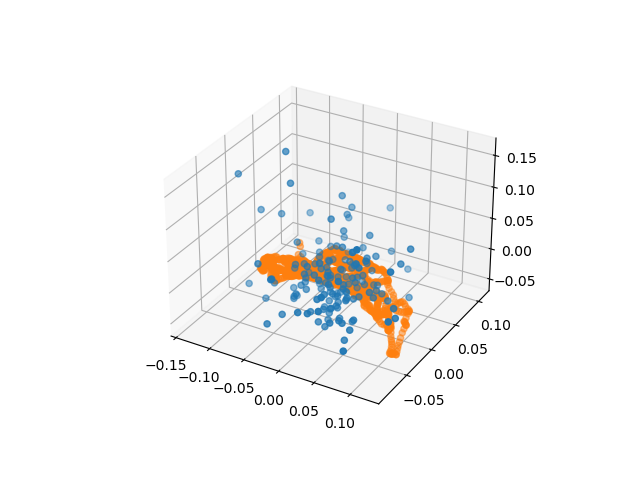

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0008_es1_beta1e-05_20220208-160757


<IPython.core.display.Javascript object>


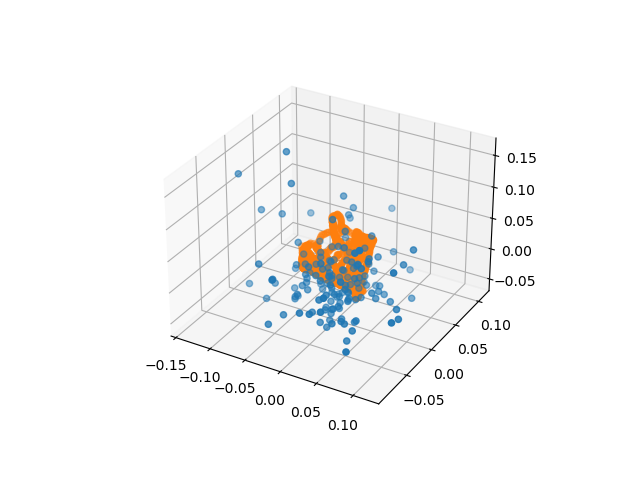

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950


<IPython.core.display.Javascript object>


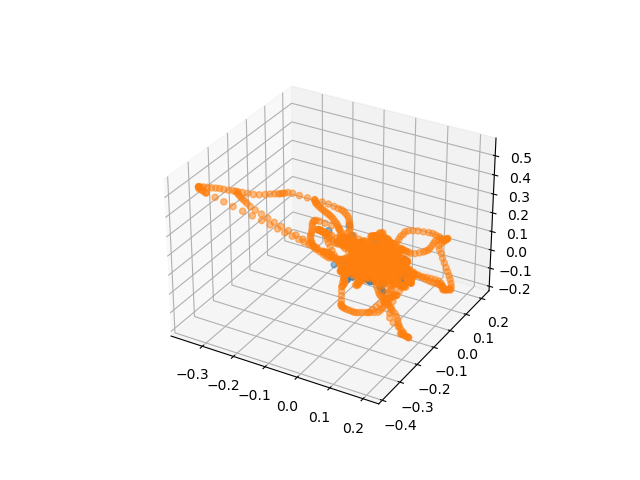

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.0001_20220208-161142


<IPython.core.display.Javascript object>


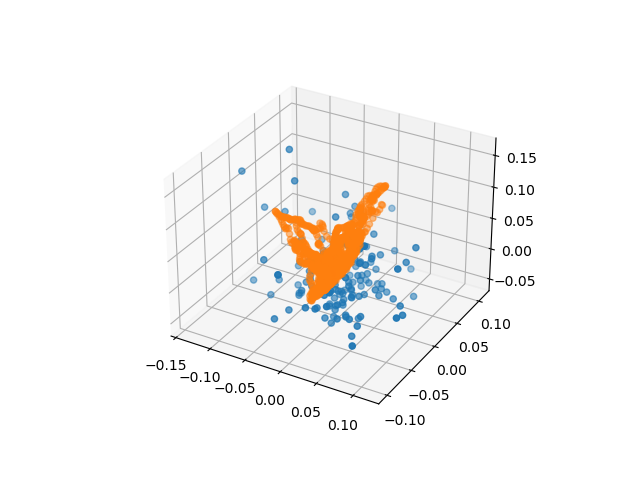

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0002_es1_beta0.0001_20220208-161334


<IPython.core.display.Javascript object>


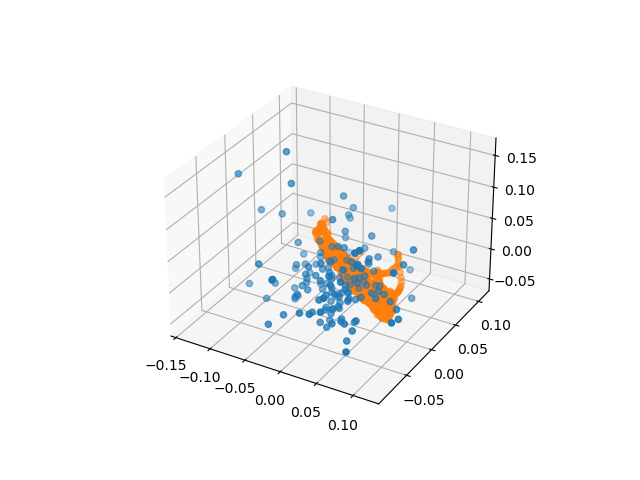

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0004_es1_beta0.0001_20220208-161528


<IPython.core.display.Javascript object>


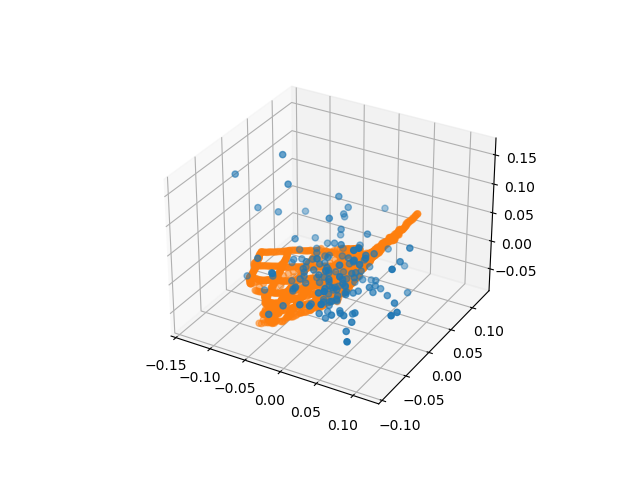

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0008_es1_beta0.0001_20220208-161720


<IPython.core.display.Javascript object>


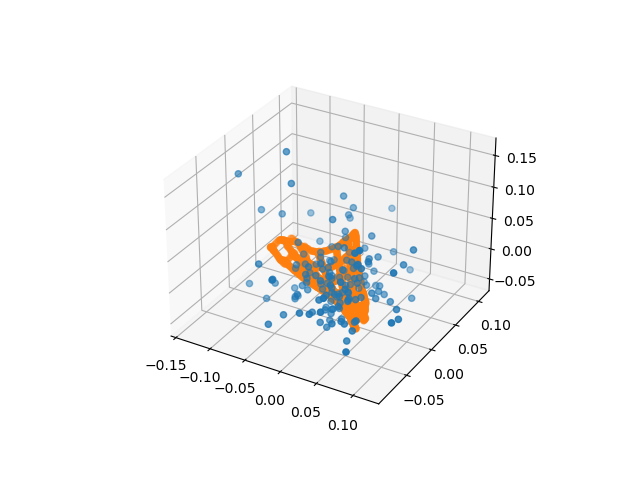

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta0.0001_20220208-161913


<IPython.core.display.Javascript object>


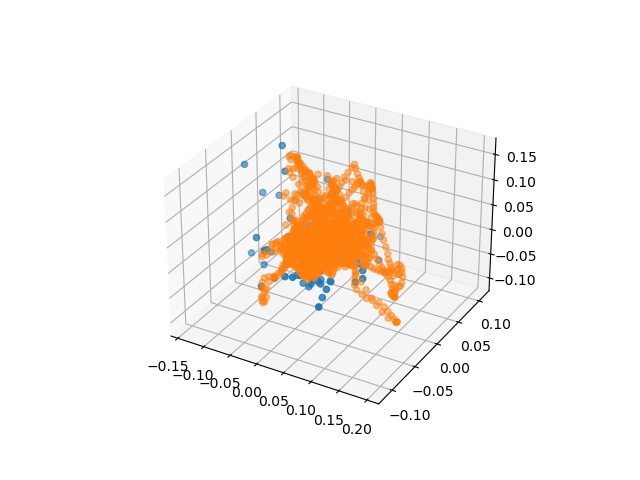

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.001_20220208-162107


<IPython.core.display.Javascript object>


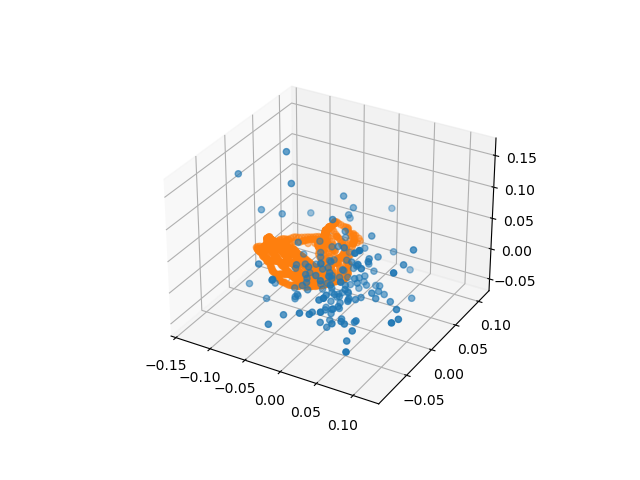

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0002_es1_beta0.001_20220208-162300


<IPython.core.display.Javascript object>


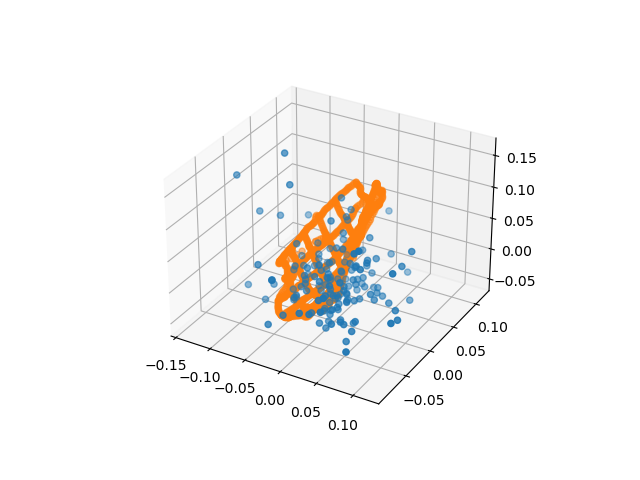

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0004_es1_beta0.001_20220208-162453


<IPython.core.display.Javascript object>


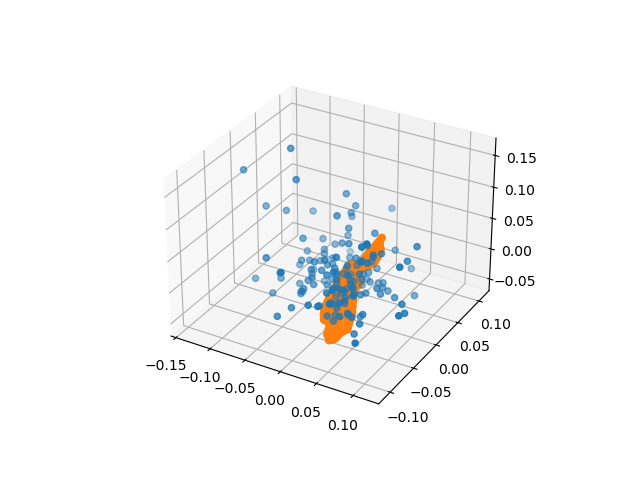

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0008_es1_beta0.001_20220208-162646


<IPython.core.display.Javascript object>


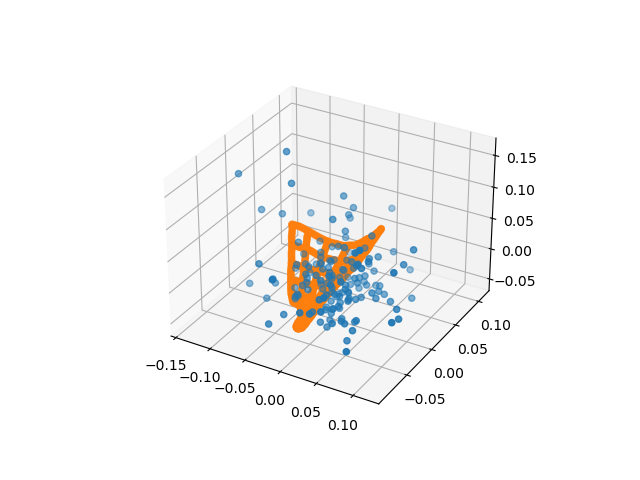

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta0.001_20220208-162838


<IPython.core.display.Javascript object>


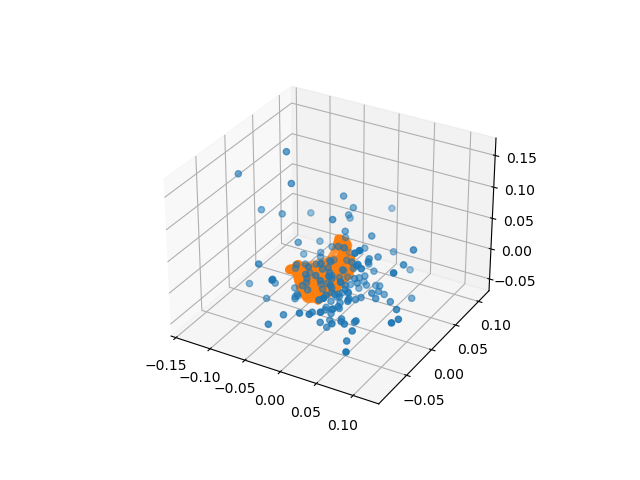

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.01_20220208-163030


<IPython.core.display.Javascript object>


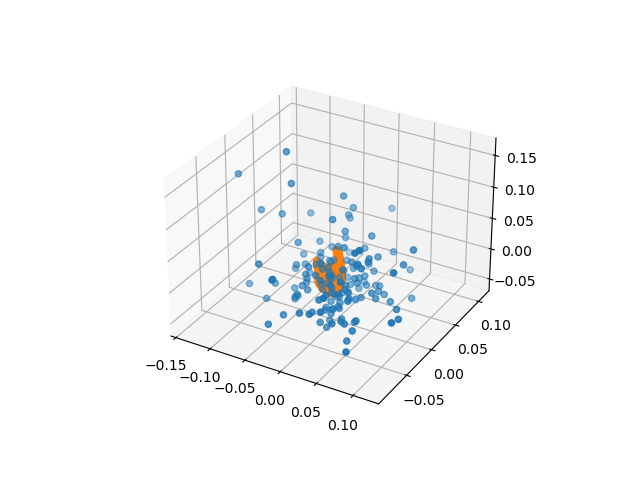

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0002_es1_beta0.01_20220208-163222


<IPython.core.display.Javascript object>


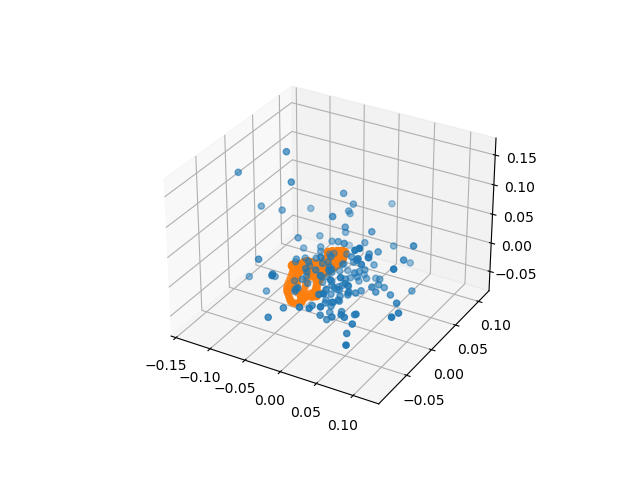

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0004_es1_beta0.01_20220208-163415


/home/tsr42/anaconda3/envs/jlonevae/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


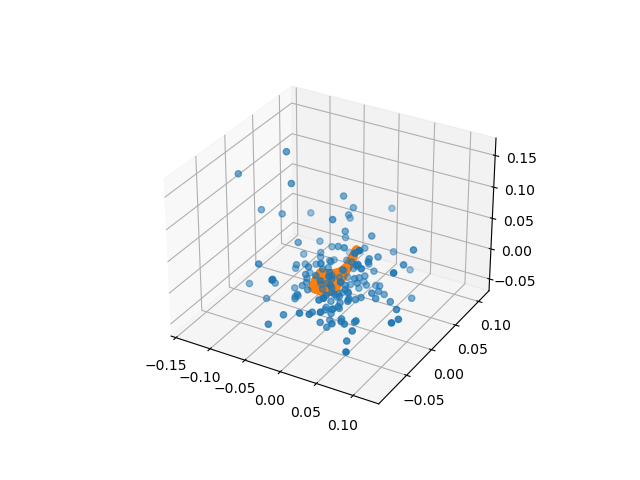

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.0008_es1_beta0.01_20220208-163608


<IPython.core.display.Javascript object>


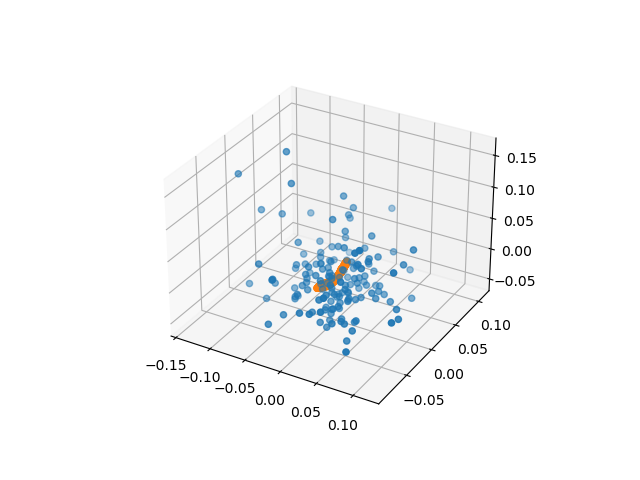

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta0.01_20220208-163801


<IPython.core.display.Javascript object>


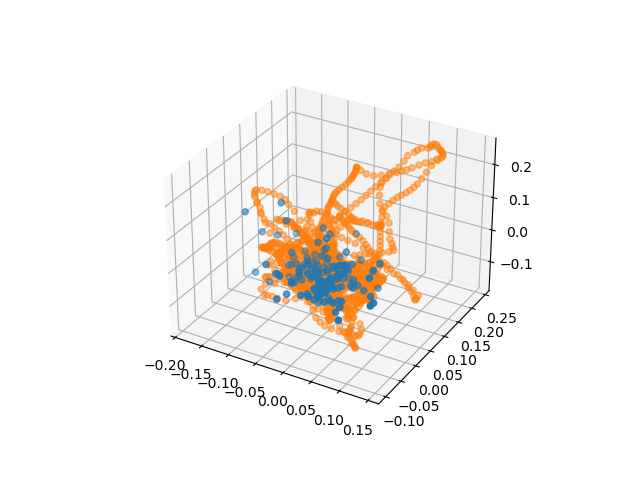

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta1e-05_20220208-163954


<IPython.core.display.Javascript object>


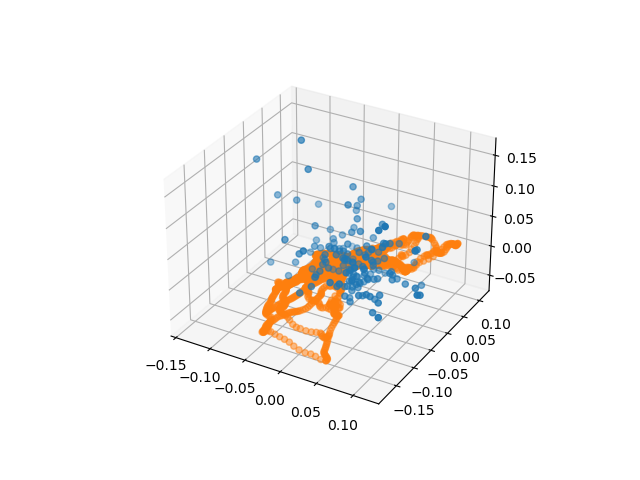

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0002_es1_beta1e-05_20220208-164146


<IPython.core.display.Javascript object>


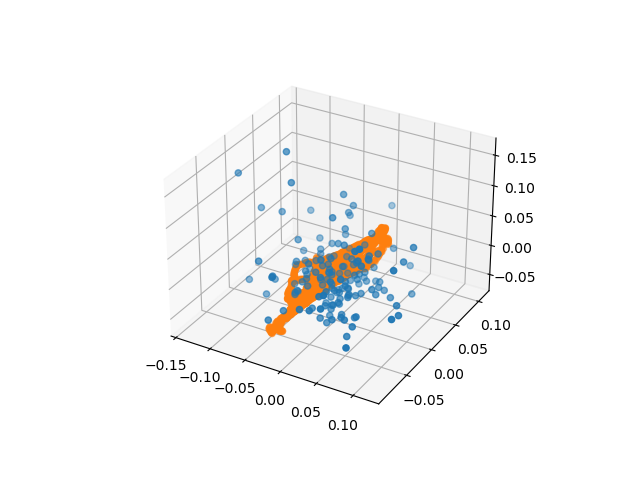

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0004_es1_beta1e-05_20220208-164339


<IPython.core.display.Javascript object>


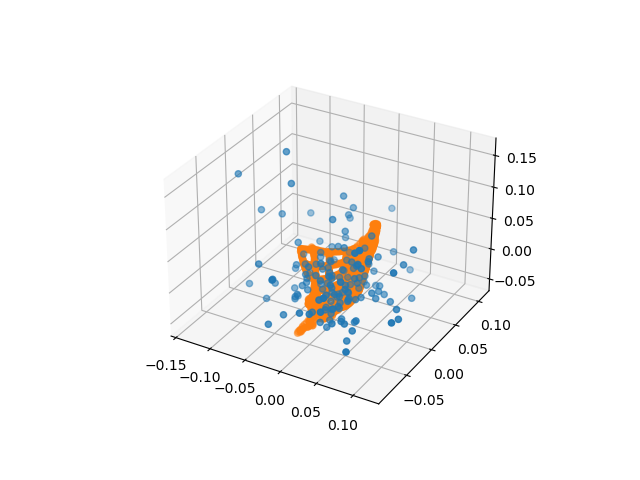

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0008_es1_beta1e-05_20220208-164533


<IPython.core.display.Javascript object>


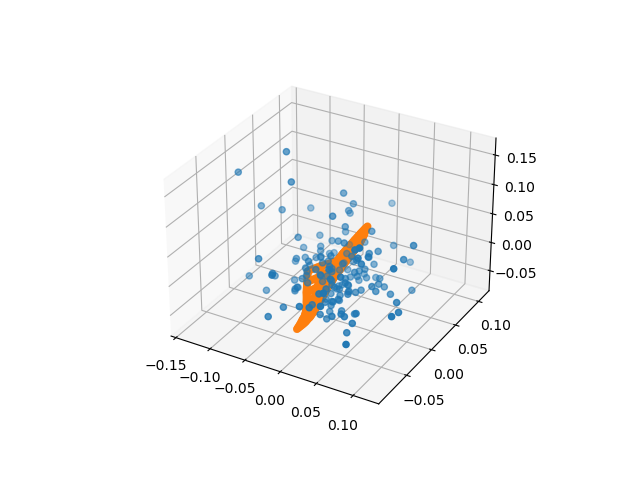

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.001_es1_beta1e-05_20220208-164726


<IPython.core.display.Javascript object>


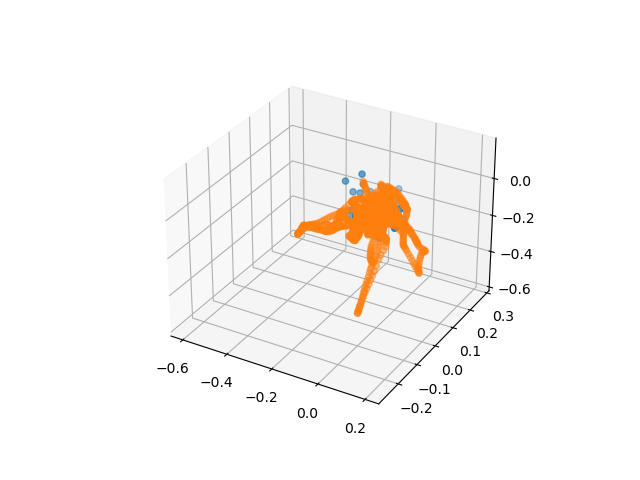

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta0.0001_20220208-164919


<IPython.core.display.Javascript object>


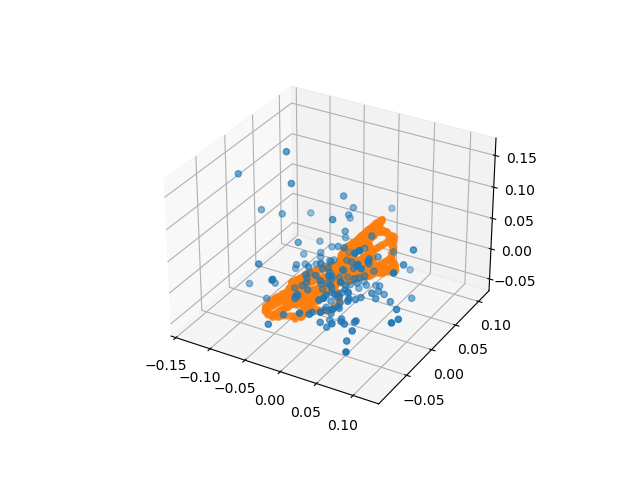

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0002_es1_beta0.0001_20220208-165112


<IPython.core.display.Javascript object>


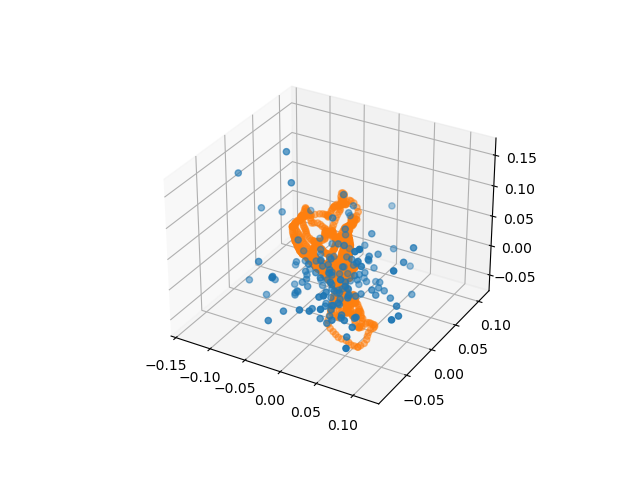

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0004_es1_beta0.0001_20220208-165304


<IPython.core.display.Javascript object>


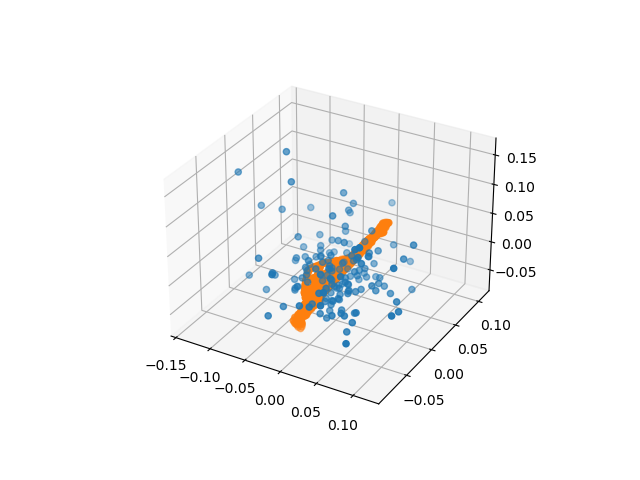

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0008_es1_beta0.0001_20220208-165456


<IPython.core.display.Javascript object>


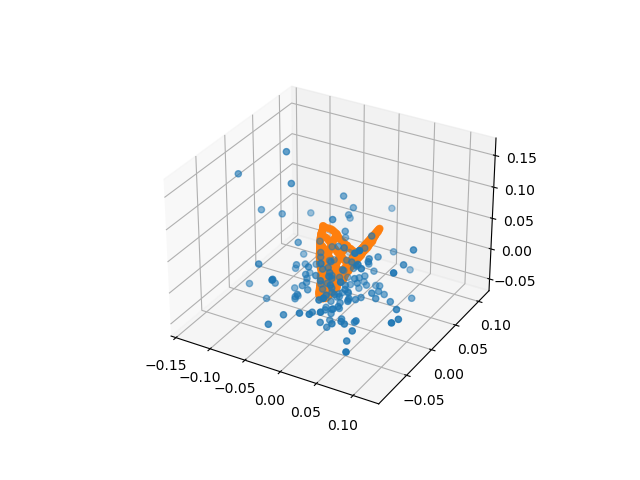

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.001_es1_beta0.0001_20220208-165648


<IPython.core.display.Javascript object>


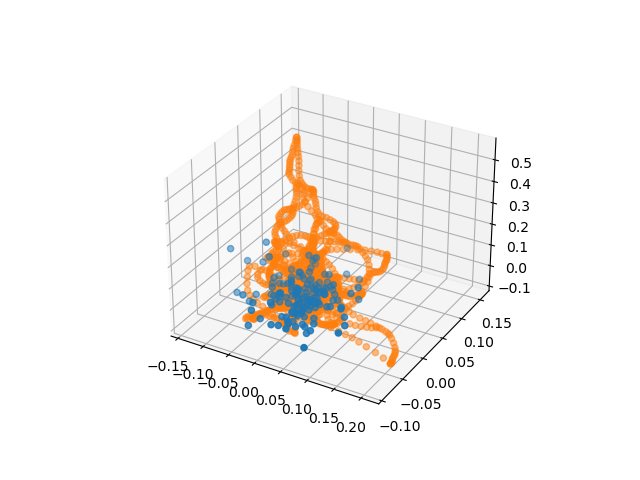

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta0.001_20220208-165841


<IPython.core.display.Javascript object>


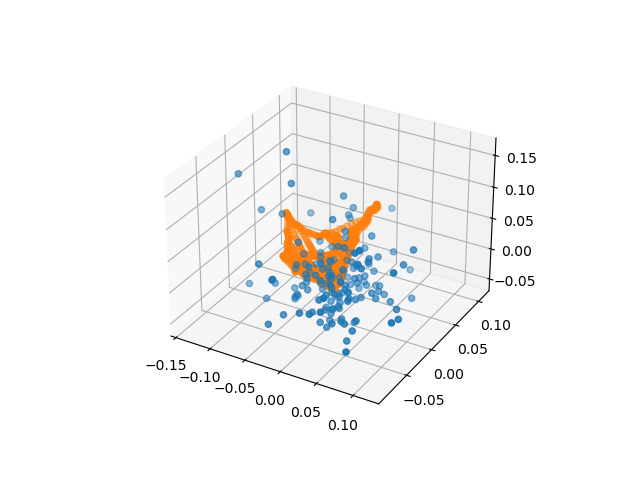

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0002_es1_beta0.001_20220208-170034


<IPython.core.display.Javascript object>


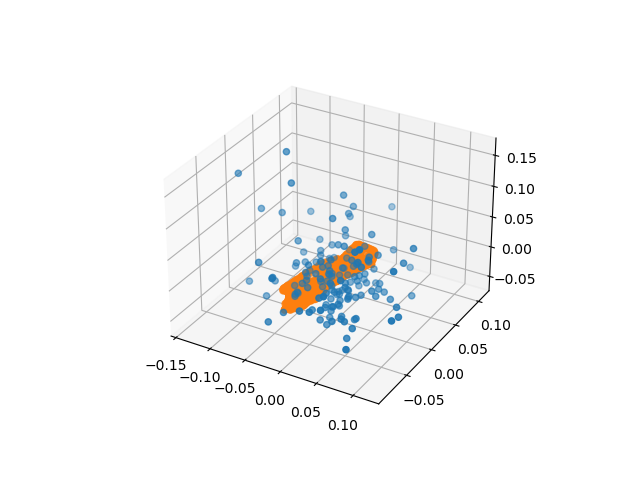

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0004_es1_beta0.001_20220208-170226


<IPython.core.display.Javascript object>


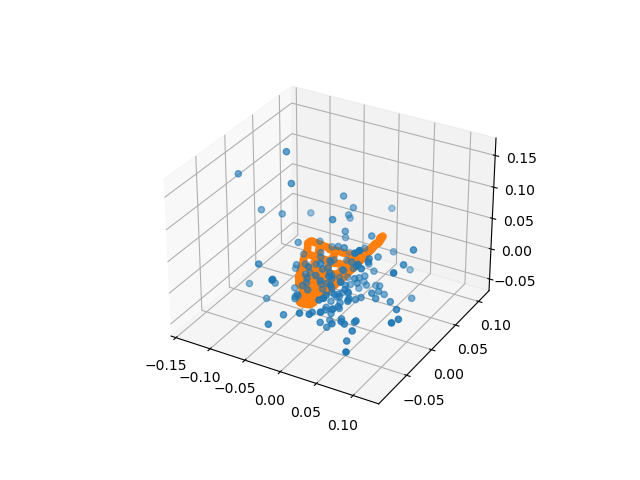

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0008_es1_beta0.001_20220208-170419


<IPython.core.display.Javascript object>


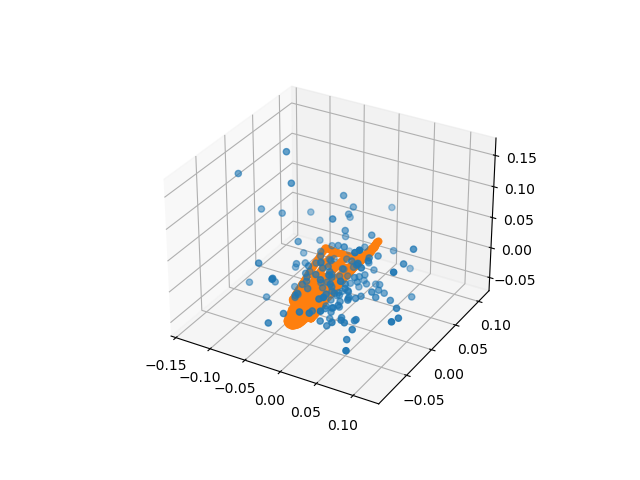

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.001_es1_beta0.001_20220208-170612


<IPython.core.display.Javascript object>


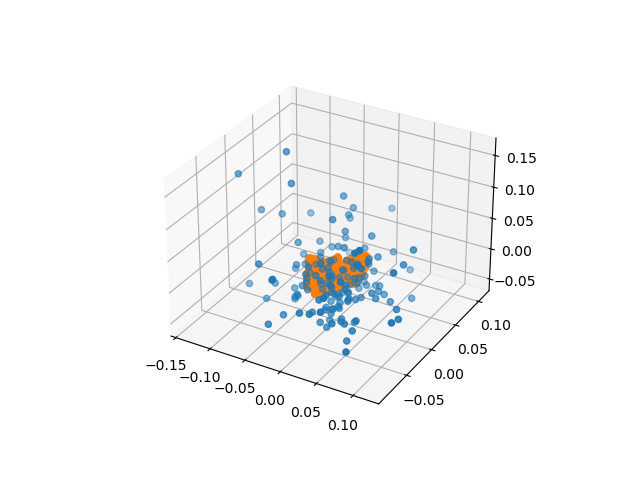

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta0.01_20220208-170805


<IPython.core.display.Javascript object>


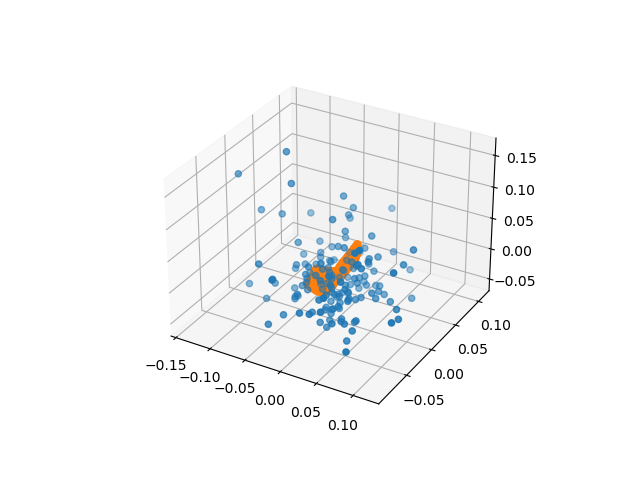

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0002_es1_beta0.01_20220208-170958


<IPython.core.display.Javascript object>


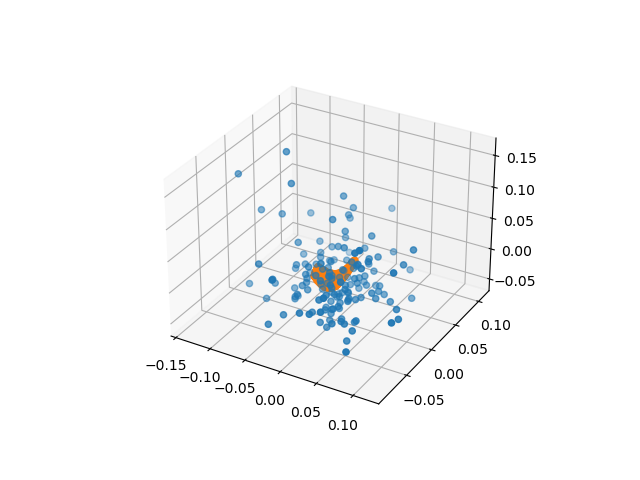

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0004_es1_beta0.01_20220208-171151


<IPython.core.display.Javascript object>


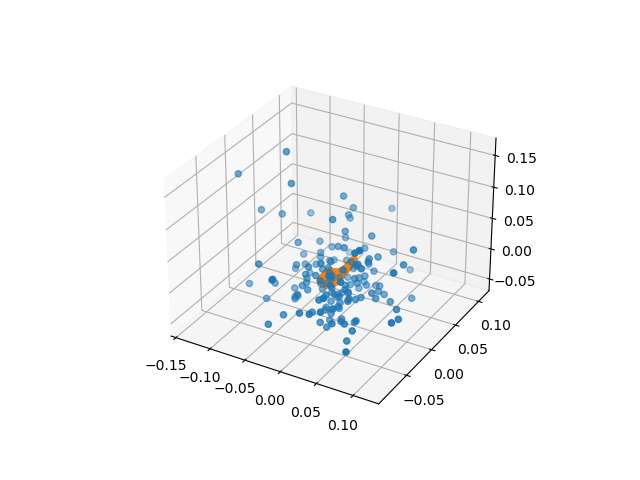

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.0008_es1_beta0.01_20220208-171343


<IPython.core.display.Javascript object>


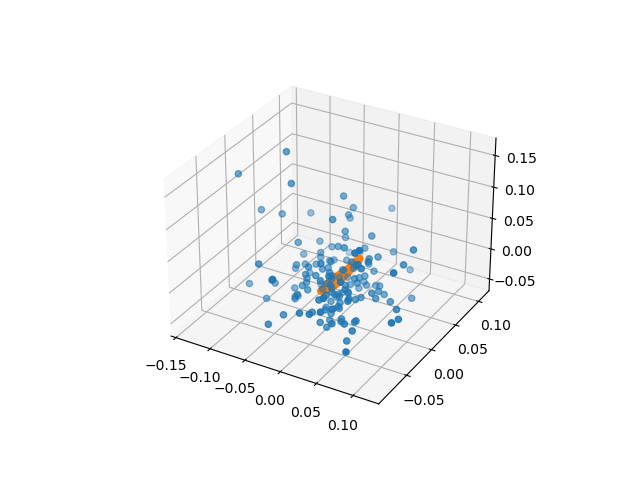

const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0.001_es1_beta0.01_20220208-171536


In [15]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = make_2d_grid_points(np.min(embeds[:,0]),np.max(embeds[:,0]),
                              np.min(embeds[:,1]),np.max(embeds[:,1]))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);
    ax.scatter(readout[:,0],readout[:,1],readout[:,2], alpha=0.5);